# **Installing libarerys**

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/wenewone/cub2002011'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/wenewone/cub2002011


100%|██████████| 1.49G/1.49G [00:39<00:00, 40.5MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
import torch.nn as nn
# from transformers import BertTokenizer, BertModel
import numpy as np
from PIL import Image
from torch.autograd import Variable
import torch.multiprocessing as mp
from tqdm.notebook import tqdm
import time
import torch.optim as optim
import random
import requests
import zipfile
import pandas as pd
import json
import time
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
%matplotlib inline

# **Dataset**

In [ ]:
def load_text(text_file_path):
    """
    Load text from a file and return it as a string.
    """
    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read().strip().split('\n')
    return text

def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids

def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings

def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames



def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict


def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img
def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir,text_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)
    X, y, embeddings,texts = [], [], [],[]

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]


        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            text_file= load_text('{}/text_c10/{}.txt'.format(text_dir, filename))
            img = get_img(img_name, bounding_box, image_size)
            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]
            text=text_file[embedding_ix]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
            texts.append(text)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)

    return X, y, embeddings,text

In [ ]:
url = 'https://github.com/brangerbriz/docker-StackGAN/releases/download/datasets/birds.zip'
response = requests.get(url)

if response.status_code == 200:
    # Write the zip file to local disk
    with open('birds.zip', 'wb') as f:
        f.write(response.content)

    # Create a directory to unzip the files into
    os.makedirs('data', exist_ok=True)

    # Unzipping the file
    with zipfile.ZipFile('birds.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
    print("Files unzipped successfully")
else:
    print("Failed to retrieve the file")


Files unzipped successfully


In [ ]:
train_image, train_label, train_embedding,train_text=load_dataset("/content/data/birds/train/filenames.pickle",
                                                                  "/content/data/birds/train/class_info.pickle",
                                                                  "/content/cub2002011/CUB_200_2011",
                                                                  "/content/cub2002011/cvpr2016_cub",
                                                                  "/content/data/birds/train/char-CNN-RNN-embeddings.pickle",
                                                                   (64,64))

<ipython-input-6-2f3eae4157d0>:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,
<ipython-input-6-2f3eae4157d0>:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)


embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)


In [ ]:
test_image, test_label, test_embedding,test_text=load_dataset("/content/data/birds/test/filenames.pickle",
                                                              "/content/data/birds/test/class_info.pickle",
                                                              "/content/cub2002011/CUB_200_2011",
                                                              "/content/cub2002011/cvpr2016_cub",
                                                              "/content//data/birds/test/char-CNN-RNN-embeddings.pickle",
                                                               (64,64))

<ipython-input-6-2f3eae4157d0>:46: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,
<ipython-input-6-2f3eae4157d0>:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)


embeddings:  (2933, 10, 1024)
Embeddings shape: (2933, 10, 1024)


In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataframe, imsize=64, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.imsize = imsize
        self.data = dataframe

    def get_img(self, image_data):
        """
        Load and transform the image.
        """
        if isinstance(image_data, str):
            img = Image.open(image_data).convert('RGB')
        elif isinstance(image_data, np.ndarray):
            img = Image.fromarray(image_data)
        else:
            raise TypeError("Unsupported image data type.")

        if self.transform is not None:
            img = self.transform(img)
        return img

    def __getitem__(self, index):
        row = self.data.iloc[index]
        # Convert the string representation of the vector to a list of floats
        vector = row['vector_emb']
        # Convert to a numpy array
#         vector = np.array([float(x) for x in vector_str.strip('[]').split() if x])
        embedding = torch.tensor(vector, dtype=torch.float32)
        img = self.get_img(row['image'])
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)
        comment = row['train_text']
        return img, embedding

    def __len__(self):
        return len(self.data)

In [ ]:
train_df=pd.DataFrame({
    "image":list(train_image),
    "train_text":train_text,
    "vector_emb":list(train_embedding)
})

In [ ]:
test_df=pd.DataFrame({
    "image":list(test_image),
    "train_text":test_text,
    "vector_emb":list(test_embedding)
})

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(64),  # Randomly crop the image to the specified size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (data augmentation)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


# Create Dataset objects
train_dataset =MyDataset(dataframe=train_df, transform=transform)


test_dataset = MyDataset(dataframe=test_df ,transform=transform)


# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [ ]:
dataloader = train_loader

# **Dataset configuration**

In [ ]:
class MatchingTextImage():
    def __init__(self, text_dir, image_dir):
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.exists(text_dir):
            raise FileNotFoundError(f"Text directory not found: {text_dir}")

        self.image_dir = image_dir
        self.text_dir = text_dir
        self.image_classes = sorted(os.listdir(image_dir))
        self.text_classes = sorted(os.listdir(text_dir))

    def filter_phase_1(self):
        self.filtered_text_classes = list(filter(lambda file: not file.endswith('.t7'), self.text_classes))
        for file_name in self.text_classes:
            file_path = os.path.join(self.text_dir, file_name)
            if file_name not in self.filtered_text_classes:
                try:
                    os.remove(file_path)
                except:
                    pass

    def filter_phase_2(self):
        for bird_name in self.text_classes:
            bird_dir = os.path.join(self.text_dir, bird_name)
            if not os.path.exists(bird_dir):
                continue
            try:
                bird_class = os.listdir(bird_dir)
                filtered_bird_classes = list(filter(lambda file: not file.endswith('.h5'), bird_class))
                for file_name in bird_class:
                    file_path = os.path.join(bird_dir, file_name)
                    if file_name not in filtered_bird_classes:
                        os.remove(file_path)
            except:
                pass

        for bird_name in os.listdir(self.image_dir):
            birdtxt_dir = os.path.join(self.text_dir, bird_name)
            birdimg_dir = os.path.join(self.image_dir, bird_name)
            if not os.path.exists(birdtxt_dir) or not os.path.exists(birdimg_dir):
                continue
            try:
                birdtxt_class = len(os.listdir(birdtxt_dir))
                birdimg_class = len(os.listdir(birdimg_dir))
                if birdtxt_class != birdimg_class:
                    files_in_folder2 = os.listdir(birdimg_dir)
                    for filename in files_in_folder2:
                        if filename.endswith('_rgb.jpg'):
                            file_path = os.path.join(birdimg_dir, filename)
                            os.remove(file_path)
            except:
                pass


In [ ]:
bird_image_dir = '/content/cub2002011/CUB_200_2011/images'
bird_text_dir = '/content/cub2002011/cvpr2016_cub/text_c10'

unfiltered_images = MatchingTextImage(text_dir=bird_text_dir , image_dir = bird_image_dir)
stage_1_cleand = unfiltered_images.filter_phase_1()
unfiltered_images.filter_phase_2()

In [ ]:
class CUBDataset(Dataset):
    def __init__(self, image_base_dir, text_base_dir, transform=None, max_length=128):

        self.image_base_dir = image_base_dir
        self.text_base_dir = text_base_dir
        self.transform = transform
        self.max_length = max_length
        self.bird_folders = sorted(os.listdir(image_base_dir))


        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
        self.bert_model = BertModel.from_pretrained('bert-large-uncased').eval()


        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert_model.to(self.device)

    def __len__(self):
        return sum(len(os.listdir(os.path.join(self.image_base_dir, folder))) for folder in self.bird_folders)

    def load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

    def load_text_embedding(self, text_path):
        with open(text_path, 'r') as file:
            caption = file.read().strip()
        inputs = self.tokenizer(caption, return_tensors="pt", truncation=True, padding="max_length", max_length=self.max_length).to(self.device)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).cpu()

        return embedding.squeeze()

    def __getitem__(self, idx):
        folder_idx = 0
        image_idx = idx
        for folder in self.bird_folders:
            folder_images = os.listdir(os.path.join(self.image_base_dir, folder))
            if image_idx < len(folder_images):
                image_file = folder_images[image_idx]
                image_path = os.path.join(self.image_base_dir, folder, image_file)
                text_path = os.path.join(self.text_base_dir, folder, f"{image_file.replace('.jpg', '.txt')}")
                image = self.load_image(image_path)
                text_embedding = self.load_text_embedding(text_path)
                return image, text_embedding
            image_idx -= len(folder_images)
        raise IndexError("Index out of range")



In [ ]:
image_base_dir = bird_image_dir
text_base_dir = bird_text_dir


transform = transforms.Compose([
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cub_dataset = CUBDataset(image_base_dir=image_base_dir, text_base_dir=text_base_dir, transform=transform)

dataloader = DataLoader(cub_dataset, batch_size=32, shuffle=True, drop_last=True, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

# **Using a GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
dataloader = DeviceDataLoader(dl=dataloader, device=get_default_device())

In [ ]:
device = get_default_device()

# **Show Sample**

In [ ]:
def show_single_sample(image, text_embedding):
    image = (image* 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.title("Sample Image with Text Embedding")
    plt.show()
    print("Text Embedding Vector")
    print(text_embedding.shape)

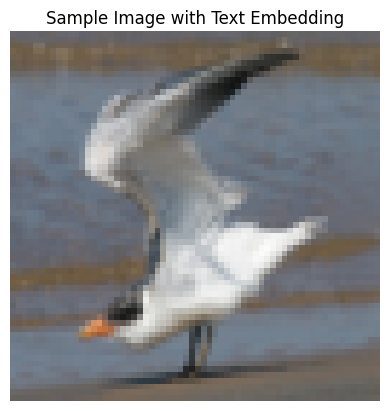

Text Embedding Vector
torch.Size([1024])


In [ ]:
images, text_embeddings = next(iter(dataloader))
show_single_sample(images[0], text_embeddings[0])

# **Models**

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block

In [ ]:
class CA_NET(nn.Module):
    # some code is modified from vae examples
    # (https://github.com/pytorch/examples/blob/master/vae/main.py)
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = 1024
        self.c_dim = 128
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True)
        self.relu = nn.ReLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()

        eps = torch.randn_like(std)

        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar


In [ ]:
class STAGE1_G(nn.Module):
    def __init__(self):
        super(STAGE1_G, self).__init__()
        self.gf_dim = 192 * 8
        self.ef_dim = 128
        self.z_dim = 100
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()

        # -> ngf x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True))

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = upBlock(ngf, ngf // 2)
        # -> ngf/4 x 16 x 16
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        # -> ngf/8 x 32 x 32
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        # -> ngf/16 x 64 x 64
        self.upsample4 = upBlock(ngf // 8, ngf // 16)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv3x3(ngf // 16, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1)
        to_device(noise, get_default_device())
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        # state size 3 x 64 x 64
        fake_img = self.img(h_code)
        return None, fake_img, mu, logvar

In [ ]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef, bcondition=True):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf # 96
        self.ef_dim = nef # 128
        self.bcondition = bcondition
        if bcondition:
            self.outlogits = nn.Sequential(
                conv3x3(ndf * 8 + nef, ndf * 8),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())
        else:
            self.outlogits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, h_code, c_code=None): # [32 , 768 , 4 , 4] , [32, 1024]
        # conditioning output
        if self.bcondition and c_code is not None:
            # print(c_code.shape,'-') # [32, 1024]
            c_code = c_code.view(-1, self.ef_dim, 1, 1) # [256, 128, 1, 1]
            # print(c_code.shape, '--')
            c_code = c_code.repeat(1, 1, 4, 4)
            # print('c code',c_code.shape , 'hcode', h_code.shape) # [32, 128, 4, 4] [32, 768, 4, 4]
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)
        else:
            h_c_code = h_code

        output = self.outlogits(h_c_code)
        return output.view(-1)


In [ ]:
class STAGE1_D(nn.Module):
    def __init__(self):
        super(STAGE1_D, self).__init__()
        self.df_dim = 96
        self.ef_dim = 128
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef)
        self.get_uncond_logits = None

    def forward(self, image, c_code=None):
        img_embedding = self.encode_img(image) # [32, 3, 64, 64] -> [32 , 768 , 4 , 4]
        if c_code is not None: # [32, 1024]
          pred = self.get_cond_logits(img_embedding, c_code)
        else:
          pred = None
        return img_embedding, pred

# **Test**

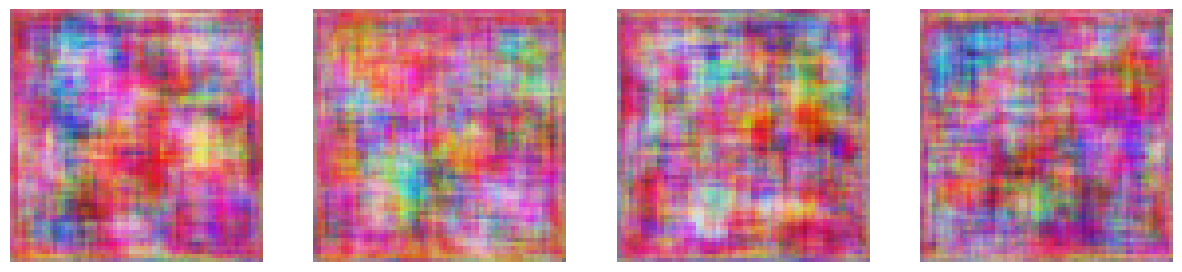

In [ ]:
generator = STAGE1_G().to(device)
discriminator = STAGE1_D().to(device)

ca_net = CA_NET().to(device)


batch_size = text_embeddings.size(0)
c_code, mu, logvar = ca_net(text_embeddings)
z_dim = generator.z_dim
noise = torch.randn(batch_size, z_dim).to(device)

with torch.no_grad():
    _, fake_images, mu, logvar = generator(text_embeddings.to(device), noise)

with torch.no_grad():
    _, realness_scores = discriminator(fake_images, c_code)  #  [32, 3, 64, 64]  , [32, 128]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    img = fake_images[i].cpu().numpy().transpose(1, 2, 0)
    img = (img + 1) / 2
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()


# print("Realness Scores for each image in the batch:")
# for i in range(4):  print(f"Image {i+1}: Score = {realness_scores[i].item():.4f}")

# del generator
# del discriminator

# **Loss Function**

In [ ]:
def compute_discriminator_loss(netD,
                               real_imgs,
                               fake_imgs,
                               real_labels,
                               fake_labels,
                               conditions,
                               get_cond_logits,):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)

    _, real_logits = netD(real_imgs, conditions)
    errD_real = criterion(real_logits, real_labels)


    _, fake_logits = netD(fake_imgs.detach(), conditions)
    # _, fake_logits = netD(fake_imgs, conditions)
    errD_fake = criterion(fake_logits, fake_labels)


    _, wrong_logits = netD(real_imgs[:(batch_size - 1)], conditions[1:])
    errD_wrong = criterion(wrong_logits, fake_labels[1:])


    errD = errD_real + (errD_fake + errD_wrong) * 0.5


    return errD, errD_real.item(), errD_wrong.item(), errD_fake.item()

In [ ]:
def compute_generator_loss(netD, fake_imgs, real_labels, conditions):
    criterion = nn.BCELoss()
    cond = conditions.detach()

    _ ,fake_logits = netD(fake_imgs, cond)

    errD_fake = criterion(fake_logits, real_labels)

    return errD_fake

In [ ]:
def KL_loss(mu, logvar):
    mu = mu.detach()
    logvar = logvar.detach()
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD

# **stage 1**

In [ ]:
def fit(dataloader, netG, netD, ca_net , ce, epochs=30, nz=100, batch_size=32, lr_g=0.0002, lr_d=0.0002, lr_decay=20):

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    generator_lr = lr_g
    discriminator_lr = lr_d
    lr_decay_step = lr_decay
    current_epoch = ce
    noise = torch.FloatTensor(batch_size, nz)


    torch.cuda.empty_cache()

    with torch.no_grad():
        fixed_noise = torch.FloatTensor(batch_size, nz).normal_(0, 1)

    real_labels = torch.FloatTensor(batch_size).fill_(1)
    fake_labels = torch.FloatTensor(batch_size).fill_(0)

    if torch.cuda.is_available():
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        real_labels, fake_labels = real_labels.cuda(), fake_labels.cuda()

    netD_para = [p for p in netD.parameters() if p.requires_grad]
    optimizerD = optim.Adam(netD_para, lr=discriminator_lr, betas=(0.5, 0.999))
    netG_para = [p for p in netG.parameters() if p.requires_grad]
    optimizerG = optim.Adam(netG_para, lr=generator_lr, betas=(0.5, 0.999))

    max_epoch = epochs

    count = 0
    for epoch in range(max_epoch):
        start_t = time.time()
        if current_epoch % lr_decay_step == 0 and epoch > 0:
            generator_lr *= 0.5
            for param_group in optimizerG.param_groups:
                param_group['lr'] = generator_lr
            discriminator_lr *= 0.5
            for param_group in optimizerD.param_groups:
                param_group['lr'] = discriminator_lr

        for images, text_embeddings in tqdm(dataloader):

            images = images.requires_grad_().cuda()
            text_embeddings = text_embeddings.requires_grad_().cuda()

            noise.data.normal_(0, 1)

            _, fake_imgs, mu, logvar = netG(text_embeddings, noise)

            netD.zero_grad()

            c_code, mu, logvar = ca_net(text_embeddings)

            errD, errD_real, errD_wrong, errD_fake = compute_discriminator_loss(
                netD,
                real_imgs=images,
                fake_imgs=fake_imgs,
                real_labels=real_labels,
                fake_labels=fake_labels,
                conditions=mu,
                get_cond_logits=True,


            )
            errD.backward()
            optimizerD.step()
            netG.zero_grad()



            errG = compute_generator_loss(netD, fake_imgs, real_labels, mu)

            kl_loss = KL_loss(mu, logvar)

            errG_total = errG + kl_loss * 2.0

            errG_total.backward()
            optimizerG.step()
            count += 1

        losses_g.append(errG_total)
        losses_d.append(errD)
        real_scores.append(errD_real)
        fake_scores.append(errD_fake)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, errG_total, errD, errD_real, errD_fake))

        end_t = time.time()

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
def save_weights(epoch, netG, netD, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(netG.state_dict(), f"{save_dir}/netG_epoch_{epoch}.pth")
    torch.save(netD.state_dict(), f"{save_dir}/netD_epoch_{epoch}.pth")
    print(f"Weights saved for epoch {epoch}")

In [ ]:
def load_weights(netG, netD, save_dir="checkpoints", epoch=None):
    if epoch:
        netG.load_state_dict(torch.load(f"{save_dir}/netG_epoch_{epoch}.pth"))
        netD.load_state_dict(torch.load(f"{save_dir}/netD_epoch_{epoch}.pth"))
        print(f"Weights loaded from epoch {epoch}")
    else:
        print("No specific epoch provided for loading weights.")

In [ ]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [ ]:
def save_samples(index, latent_tensors, generator , cond ,sample_dir="samples", show=True):
    os.makedirs(sample_dir, exist_ok=True)
    _, fake_imges, _, _ = generator(cond ,latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(4, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [ ]:
def load_logs(load_path):
    try:
        with open(load_path, 'rb') as f:
            logs = pickle.load(f)
        print(f"Logs loaded from {load_path}")
        return logs
    except FileNotFoundError:
        print(f"No existing logs found at {load_path}, starting fresh.")
        return {"losses_g": [], "losses_d": [], "real_scores": [], "fake_scores": []}


In [ ]:
def save_logs(logs, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(logs, f)
    print(f"Logs saved to {save_path}")

In [ ]:
def train_one_stage_fixed_epochs(dataloader, netG, netD, ca_net, current_epoch, text_embeddings, stage_epochs=10, nz=100, save_dir="checkpoints", sample_dir="samples", log_path="logs.pkl", **fit_kwargs):
    """

    Args:
      dataloader:
      netG:
      netD:
      ca_net:
      current_epoch:
      text_embeddings:
      stage_epochs:
      nz:
      save_dir:
      sample_dir:
      log_path:
      **fit_kwargs:

    Returns:

    """

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)

    logs = load_logs(log_path)

    print(f"\n=== Training for epochs {current_epoch + 1} to {current_epoch + stage_epochs} ===")


    if current_epoch > 0:
        load_weights(netG, netD, save_dir=save_dir, epoch=current_epoch)


    losses_g, losses_d, real_scores, fake_scores = fit(
        dataloader=dataloader,
        netG=netG,
        netD=netD,
        ca_net=ca_net,
        epochs=stage_epochs,
        ce = current_epoch,
        **fit_kwargs
    )

    logs["losses_g"].extend(losses_g)
    logs["losses_d"].extend(losses_d)
    logs["real_scores"].extend(real_scores)
    logs["fake_scores"].extend(fake_scores)
    save_logs(logs, log_path)


    current_epoch += stage_epochs
    save_weights(current_epoch, netG, netD, save_dir=save_dir)

    with torch.no_grad():
        # _ , text_embeddings = next(iter(dataloader))
        text_embeddings = text_embeddings.to(next(netG.parameters()).device)
        latent_tensors = torch.randn(32, nz).to(next(netG.parameters()).device)
        save_samples(current_epoch, latent_tensors, netG , text_embeddings ,sample_dir=sample_dir, show=False)

    print(f"\nTraining complete for epochs {current_epoch - stage_epochs + 1} to {current_epoch}!")
    return current_epoch

In [ ]:
_ , text_embeddings = next(iter(dataloader))

In [ ]:
netG = STAGE1_G().to(device)
netD = STAGE1_D().to(device)
ca_net = CA_NET().to(device)
current_epoch = 0

In [ ]:
current_epoch = train_one_stage_fixed_epochs(
    dataloader=dataloader,
    netG=netG,
    netD=netD,
    ca_net=ca_net,
    current_epoch=current_epoch,
    text_embeddings = text_embeddings,
    stage_epochs=20,
    nz=100,
    batch_size=32,
    lr_g=0.0002,
    lr_d=0.0002,
    lr_decay=20,
    save_dir="checkpoints",
    sample_dir="samples",
    log_path="logs.pkl"
)


Logs loaded from logs.pkl

=== Training for epochs 101 to 120 ===
Weights loaded from epoch 100


<ipython-input-31-04d20317d6dd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(f"{save_dir}/netG_epoch_{epoch}.pth"))
<ipython-input-31-04d

  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 8.8342, loss_d: 0.0579, real_score: 0.0559, fake_score: 0.0011


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 5.1096, loss_d: 0.0291, real_score: 0.0094, fake_score: 0.0393


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 4.9906, loss_d: 0.0267, real_score: 0.0178, fake_score: 0.0167


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 4.5448, loss_d: 0.0167, real_score: 0.0059, fake_score: 0.0207


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 5.1977, loss_d: 0.0178, real_score: 0.0127, fake_score: 0.0101


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 8.9572, loss_d: 0.0062, real_score: 0.0060, fake_score: 0.0004


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 4.8793, loss_d: 0.0170, real_score: 0.0091, fake_score: 0.0125


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 3.9951, loss_d: 0.0249, real_score: 0.0058, fake_score: 0.0374


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 5.5124, loss_d: 0.0047, real_score: 0.0007, fake_score: 0.0074


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 4.8371, loss_d: 0.0129, real_score: 0.0049, fake_score: 0.0160


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 3.4449, loss_d: 0.0315, real_score: 0.0043, fake_score: 0.0543


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 3.5696, loss_d: 0.0323, real_score: 0.0056, fake_score: 0.0534


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 6.1471, loss_d: 0.0215, real_score: 0.0196, fake_score: 0.0037


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 5.2267, loss_d: 0.0167, real_score: 0.0017, fake_score: 0.0093


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 5.7329, loss_d: 0.0310, real_score: 0.0140, fake_score: 0.0052


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 5.4421, loss_d: 0.0064, real_score: 0.0022, fake_score: 0.0082


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 6.2263, loss_d: 0.0986, real_score: 0.0929, fake_score: 0.0039


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 5.8764, loss_d: 0.0047, real_score: 0.0001, fake_score: 0.0049


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 7.0967, loss_d: 0.0111, real_score: 0.0103, fake_score: 0.0015


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 4.1089, loss_d: 0.0138, real_score: 0.0003, fake_score: 0.0243
Logs saved to logs.pkl
Weights saved for epoch 120
Saving generated-images-0120.png

Training complete for epochs 101 to 120!


# Result

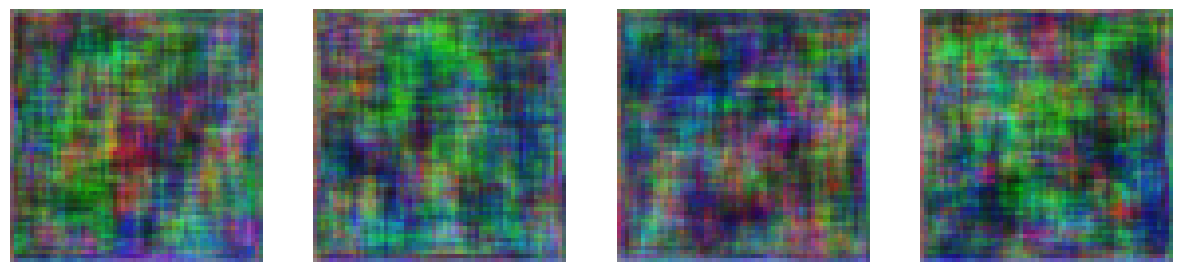

In [ ]:
# # _ , text_embeddings = next(iter(dataloader))
# batch_size = text_embeddings.size(0)
# # c_code, mu, logvar = ca_net(text_embeddings)
# z_dim = netG.z_dim
# noise = torch.randn(batch_size, z_dim).to(device)

# with torch.no_grad():
#     _, fake_images, mu, logvar = netG(text_embeddings.to(device), noise)
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# for i in range(4):
#     img = fake_images[i].cpu().numpy().transpose(1, 2, 0)
#     img = (img + 1) / 2
#     axes[i].imshow(img)
#     axes[i].axis('off')
# plt.show()


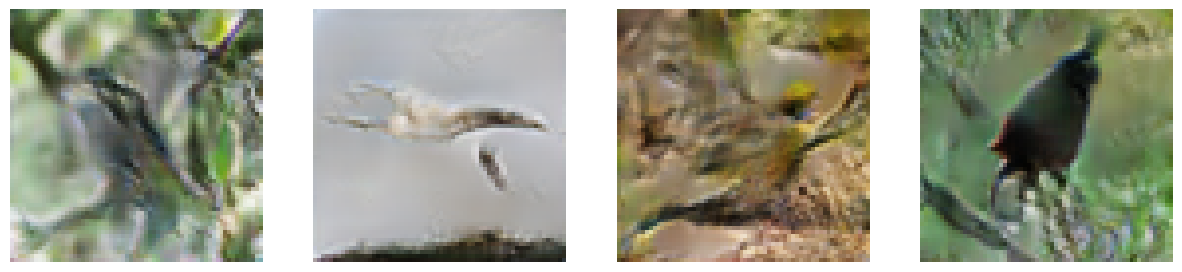

In [ ]:
# _ , text_embeddings = next(iter(dataloader))
batch_size = text_embeddings.size(0)
# c_code, mu, logvar = ca_net(text_embeddings)
z_dim = netG.z_dim
noise = torch.randn(batch_size, z_dim).to(device)

with torch.no_grad():
    _, fake_images, mu, logvar = netG(text_embeddings.to(device), noise)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    img = fake_images[i].cpu().numpy().transpose(1, 2, 0)
    img = (img + 1) / 2
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

Saving generated-images-0120.png


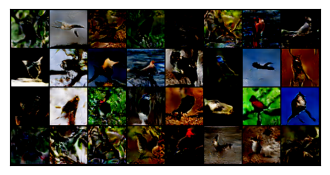

In [ ]:
save_samples(index=current_epoch, cond=text_embeddings, generator=netG, latent_tensors=noise, sample_dir='samples')